In [11]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
dataset = load_dataset("Kanakmi/mental-disorders")
num_labels = len(set(dataset["train"]["label"]))

# Tokenizer and model
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

# Preprocess
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Dataloaders
train_loader = DataLoader(dataset["train"], batch_size=16, shuffle=True)
test_loader = DataLoader(dataset["test"], batch_size=16)

# Optimizer and loss
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = CrossEntropyLoss()

# Training loop
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

print("Training complete.")


Repo card metadata block was not found. Setting CardData to empty.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/465051 [00:00<?, ? examples/s]

Map:   0%|          | 0/23190 [00:00<?, ? examples/s]

Map:   0%|          | 0/92976 [00:00<?, ? examples/s]

Epoch 1:   1%|          | 316/29066 [02:17<3:28:09,  2.30it/s, loss=0.608]


KeyboardInterrupt: 

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

model.eval()
all_preds = []
all_labels = []
all_texts = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store raw text if you want CSV output
        batch_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        all_texts.extend(batch_texts)

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Evaluating: 100%|██████████| 1450/1450 [02:45<00:00,  8.76it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      8472
           1       0.55      0.51      0.53      1405
           2       0.61      0.74      0.67      4877
           3       0.70      0.87      0.77      6440
           4       0.00      0.00      0.00       467
           5       0.79      0.02      0.03      1529

    accuracy                           0.70     23190
   macro avg       0.58      0.48      0.46     23190
weighted avg       0.70      0.70      0.67     23190


Confusion Matrix:
[[6319  128 1215  809    0    1]
 [ 157  720  205  321    0    2]
 [ 518   65 3609  685    0    0]
 [ 408   60  364 5608    0    0]
 [  37  186   70  170    0    4]
 [ 418  144  466  474    0   27]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

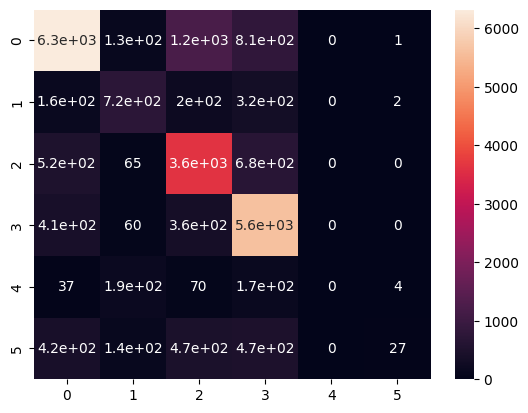

In [15]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm, annot=True)